# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import os

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
os.chdir('/content/gdrive/My Drive/Ramajayam_Gautham_112965275_hw4')
#Reference - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [0]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def zero_centered_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  #
  return 2 * (np.float32(img) / 255 - 0.5)

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(zero_centered_norm(img))
            
    #
    # Write your Data Augmentation code here
    # mirroring
    #
            
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    #
    if augment:
        #flip
        flip_hor_data = [np.flip(img, 1) for img in data]
        data.extend(flip_hor_data)
        labels.extend(labels)
        
        #flip vertically
        flip_ver_data = [np.flip(img, 0) for img in data]
        data.extend(flip_ver_data)
        labels.extend(labels)

    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Forest', 1: 'Industrial', 2: 'Flower', 3: 'Coast', 4: 'InsideCity', 5: 'Office', 6: 'Bedroom', 7: 'Highway', 8: 'Street', 9: 'TallBuilding', 10: 'LivingRoom', 11: 'Suburb', 12: 'OpenCountry', 13: 'Mountain', 14: 'Kitchen', 15: 'Store'} 


In [0]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
9600
50
Finish loading 192 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class

Kitchen


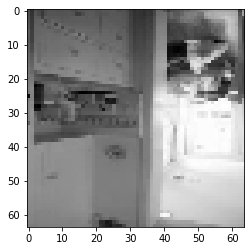

In [0]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [0]:
def train_model(dataloaders, model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    dataset_sizes = {split: len(dataloaders[split]) * batch_num \
                    for split in dataloaders}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                #a = time.time()
                model.eval()   
                #print(time.time() - a)

            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device) 
               
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [0]:
"""
def CNN_train(dataloaders, model, criterion, optimizer, scheduler=None, num_epochs=20):
    start = time.time()

    weights_best = copy.deepcopy(model.state_dict())
    accuracy_best = 0.0
    
    dataset_sizes = {split: len(dataloaders[split]) * batch_num \
                    for split in dataloaders}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device) 
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'test' and epoch_acc > best_acc:
                accuracy_best = epoch_acc
                weights_best = copy.deepcopy(model.state_dict())

    end = time.time() - start
    print('Training took {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, end % 60))
    print('Best Testing Accuracy: {:4f}'.format(accuracy_best))
    
    model.load_state_dict(weights_best)
    return model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.bn1 = nn.BatchNorm1d(16 * 13 * 13)
        self.fc1 = nn.Linear(16 * 13 * 13, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 16)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.4, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc3(x)
        return x

net = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)    
"""

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.bn1 = nn.BatchNorm1d(16 * 13 * 13)
        self.fc1 = nn.Linear(16 * 13 * 13, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 16)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.4, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc3(x)
        return x

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm1d(2704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2704, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
)

In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import copy

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
n_epochs = 60

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dataloaders = {'train': trainloader_small, 
               'val': testloader_small}

model = train_model(dataloaders, net, criterion, optimizer, exp_lr_scheduler,
                       num_epochs = n_epochs)

Epoch 0/59
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.2746 Acc: 0.2517
val Loss: 2.0773 Acc: 0.3300
Epoch 1/59
----------
train Loss: 1.7942 Acc: 0.3934
val Loss: 1.7549 Acc: 0.4100
Epoch 2/59
----------
train Loss: 1.5030 Acc: 0.4950
val Loss: 1.6069 Acc: 0.4450
Epoch 3/59
----------
train Loss: 1.2385 Acc: 0.5805
val Loss: 1.5561 Acc: 0.5000
Epoch 4/59
----------
train Loss: 1.0188 Acc: 0.6497
val Loss: 1.7604 Acc: 0.5150
Epoch 5/59
----------
train Loss: 0.8733 Acc: 0.6982
val Loss: 1.5761 Acc: 0.5700
Epoch 6/59
----------
train Loss: 0.5741 Acc: 0.8050
val Loss: 1.3752 Acc: 0.6225
Epoch 7/59
----------
train Loss: 0.4869 Acc: 0.8383
val Loss: 1.3927 Acc: 0.6200
Epoch 8/59
----------
train Loss: 0.4457 Acc: 0.8491
val Loss: 1.4155 Acc: 0.6100
Epoch 9/59
----------
train Loss: 0.4122 Acc: 0.8601
val Loss: 1.4246 Acc: 0.6075
Epoch 10/59
----------
train Loss: 0.3719 Acc: 0.8735
val Loss: 1.4632 Acc: 0.6175
Epoch 11/59
----------
train Loss: 0.3481 Acc: 0.8835
val Loss: 1.4699 Acc: 0.6125
Epoch 12/59
----------
train Loss: 0

#**Report**
Reference - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

**Final Network Layout:**

Data augmentation: Using starter code - Mirroring/Flip 

Data normalization: Included in starter code - Zero Centering 

CNN(

  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))

  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))

  (bn1): BatchNorm1d(2704, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (fc1): Linear(in_features=2704, out_features=1024, bias=True)

  (fc2): Linear(in_features=1024, out_features=128, bias=True)

  (fc3): Linear(in_features=128, out_features=16, bias=True)

)

Dropout: Dropout(p=0.1) - Used between 1st and 2nd conv layers

Dropout: Dropout(p=0.4) - Used between 1st and 2nd fc layers 

Dropout: Dropout(p=0.2) - Used between last two fc layers

**Parameters**

learning rate = 0.01, momentum=0.9

StepLR(optimizer, step_size=7, gamma=0.1) - For every 7 epochs, lr was reduced by a factor of gamma

**Total Time Taken**

Training of 60 epochs along with evaluating at each epoch - 22m 3s (Runtime type was reset to cpu while training. Noticed it after running the code.)

With GPU - 1m 56s ( Testing at each epoch - 0.00010371208190917969 seconds)

**Techniques**

**Batch Normalization**

Batch norm layer was added after 2nd conv layer. This led to increase in accuracy. (From 59.75% to 61.50%)

**Network Modification**

First conv layer was modified to produce feature maps of size 64x64. 

(conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1)

Additional fc layer was added. This led to increase in accuracy. (From 61.50% to 64.00%)

Playing with Dropout:

For Dropout with 0.5 in last two fc layers - Best Acc: 60.7500 %

For Dropout with 0.2 in last two fc layers - Best Acc: 63.5000 %

**Activation Functions**

**ReLU:**

train Loss: 0.2088 Acc: 0.9319

val Loss: 1.4234 Acc: 0.6300

Training complete in 1m 56s

Best val Acc: 0.635000

**Leaky ReLU:**

train Loss: 0.2081 Acc: 0.9308

val Loss: 1.4292 Acc: 0.6225

Training complete in 1m 56s

Best val Acc: 0.630000

**tanh:**

train Loss: 0.2947 Acc: 0.9186

val Loss: 1.3280 Acc: 0.6100

Training complete in 1m 56s

Best val Acc: 0.610000

**sigmoid:**

train Loss: 2.1133 Acc: 0.2913

val Loss: 2.1571 Acc: 0.3025

Training complete in 1m 56s

Best val Acc: 0.307500


## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import os

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import copy

# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('/content/gdrive/My Drive/Ramajayam_Gautham_112965275_hw4/data/train/', img_size, batch_num=batch_num, shuffle=True, augment=False, is_color=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('/content/gdrive/My Drive/Ramajayam_Gautham_112965275_hw4/data/test/', img_size, num_per_class=100, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

dataloaders_large = {'train': trainloader_large, 
               'val': testloader_large}

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class:

In [0]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================

alexnet = models.alexnet(pretrained=True)
num_classes = 16

num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs,num_classes)

alexnet = alexnet.to(device)

criterion_ft = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(dataloaders_large, alexnet, criterion_ft, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.1319 Acc: 0.6412
val Loss: 0.5590 Acc: 0.8125
Epoch 1/19
----------
train Loss: 0.4185 Acc: 0.8521
val Loss: 0.4961 Acc: 0.8400
Epoch 2/19
----------
train Loss: 0.3116 Acc: 0.8975
val Loss: 0.4318 Acc: 0.8525
Epoch 3/19
----------
train Loss: 0.2194 Acc: 0.9217
val Loss: 0.4948 Acc: 0.8300
Epoch 4/19
----------
train Loss: 0.1567 Acc: 0.9450
val Loss: 0.5027 Acc: 0.8300
Epoch 5/19
----------
train Loss: 0.1649 Acc: 0.9433
val Loss: 0.4921 Acc: 0.8250
Epoch 6/19
----------
train Loss: 0.0954 Acc: 0.9654
val Loss: 0.4059 Acc: 0.8725
Epoch 7/19
----------
train Loss: 0.0753 Acc: 0.9796
val Loss: 0.4128 Acc: 0.8700
Epoch 8/19
----------
train Loss: 0.0779 Acc: 0.9742
val Loss: 0.4251 Acc: 0.8600
Epoch 9/19
----------
train Loss: 0.0638 Acc: 0.9838
val Loss: 0.4202 Acc: 0.8650
Epoch 10/19
----------
train Loss: 0.0644 Acc: 0.9800
val Loss: 0.4249 Acc: 0.8675
Epoch 11/19
----------
train Loss: 0.0624 Acc: 0.9817
val Loss: 0.4193 Acc: 0.8700
Epoch 12/19
----------
train Loss: 0

In [0]:
# ==========================================
#       Strategy A with SVM
# ==========================================
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

start = time.time()
model = models.alexnet(pretrained=True)
del model.classifier[6]

train_features = np.concatenate([model(inputs).narrow(1,0,1000).detach().numpy() for inputs, _ in trainloader_large])
test_features = np.concatenate([model(inputs).narrow(1,0,1000).detach().numpy() for inputs, _ in testloader_large])

train_labels = np.concatenate([labels for _, labels in trainloader_large])
test_labels = np.concatenate([labels for _, labels in testloader_large])

SVM_classifier = LinearSVC()
SVM_classifier.fit(train_features, train_labels)
preds = SVM_classifier.predict(test_features)

print("Accuracy SVM Classifier = %f %%"% (accuracy_score(test_labels, preds) * 100))
print("SVM took %.2f seconds"% (time.time() - start))

Accuracy SVM Classifier = 75.000000 %
SVM took 81.89 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#**Report**

**Strategy A**

Accuracy of SVM Classifier = 75.000000 %

SVM took 81.89 seconds

**Strategy B**

Modification of Alexnet layers:

Alexnet was originally used for ImageNet with 1000 classes. For this problem last layer was changed to output 16 classes. No other changes were made to Alexnet.

Best Accuracy - 87.7500 % - 20 Epochs

Time taken - 71m 22s (Including evaluating test at each epoch) (When initially running, runtime type had been reset. Found this after running the code.)  



In [0]:
#Bonus

vgg11 = models.vgg11(pretrained=True)
num_classes = 16

num_ftrs = vgg11.classifier[6].in_features
vgg11.classifier[6] = nn.Linear(num_ftrs,num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vgg11 = vgg11.to(device)

criterion_ft = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg11.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft_vgg11 = train_model(dataloaders_large, vgg11, criterion_ft, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

cuda:0
Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.4279 Acc: 0.5479
val Loss: 0.5034 Acc: 0.8175
Epoch 1/19
----------
train Loss: 0.3788 Acc: 0.8683
val Loss: 0.3250 Acc: 0.8850
Epoch 2/19
----------
train Loss: 0.2256 Acc: 0.9242
val Loss: 0.2674 Acc: 0.9050
Epoch 3/19
----------
train Loss: 0.1818 Acc: 0.9346
val Loss: 0.3220 Acc: 0.8950
Epoch 4/19
----------
train Loss: 0.1388 Acc: 0.9508
val Loss: 0.2992 Acc: 0.8850
Epoch 5/19
----------
train Loss: 0.0976 Acc: 0.9654
val Loss: 0.2853 Acc: 0.8975
Epoch 6/19
----------
train Loss: 0.0530 Acc: 0.9829
val Loss: 0.2309 Acc: 0.9200
Epoch 7/19
----------
train Loss: 0.0368 Acc: 0.9908
val Loss: 0.2329 Acc: 0.9225
Epoch 8/19
----------
train Loss: 0.0399 Acc: 0.9867
val Loss: 0.2383 Acc: 0.9225
Epoch 9/19
----------
train Loss: 0.0337 Acc: 0.9908
val Loss: 0.2271 Acc: 0.9250
Epoch 10/19
----------
train Loss: 0.0331 Acc: 0.9883
val Loss: 0.2249 Acc: 0.9300
Epoch 11/19
----------
train Loss: 0.0315 Acc: 0.9917
val Loss: 0.2239 Acc: 0.9250
Epoch 12/19
----------
train Loss: 0

#**Report on VGG11 vs Alexnet**

Accuracy of Alexnet - 87.75 %

Accuracy of VGG11 - 93.00 %

Total time taken for training and evaluating (VGG11) - 13m 2s

VGG11 seems to perform better stating from epoch 1 itself. Use of fixed kernel size of 3x3 along with increase in number of kernels seems to reduce the number of training variables (Reproducing the results of 5x5 or 11x11 only using multiple 3x3 kernels). This leads to speedup in training and decreases the overfitting of model. 

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
        |---Surname_Givenname_SBUID_hw*.pdf
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.py
        |---Jordan_Michael_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.